# ICEGRAV Real Application

Apply the dual-layer gradient-boosted (GB) equivalent sources (EQS) approach with block K-fold cross validation (CV) to the real ICEGRAV data. The data file needed was created in notebook 04_icegrav_datasets.ipynb.

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error
from pathlib import Path
from IPython.display import Image
import warnings
import time

In [44]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data

In [45]:
icegrav = pd.read_csv('../data/icegrav.csv', header=0)
coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 30)]).T

In [46]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

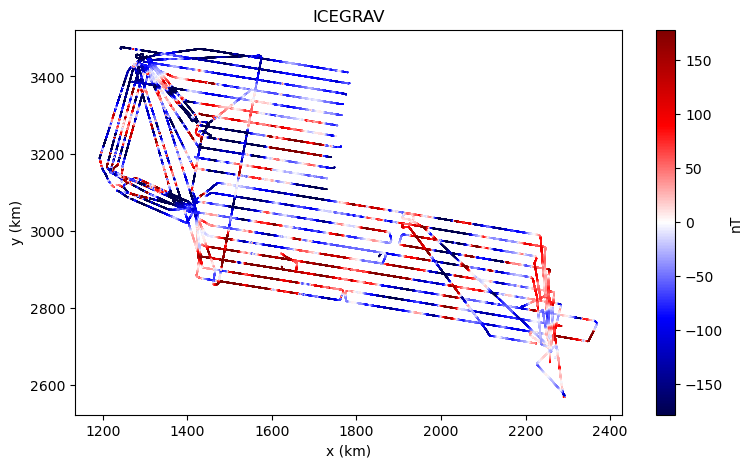

In [47]:
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
scale_icegrav = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav)
plt.title("ICEGRAV")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Fit Deep EQS layer

In [48]:
block_spacing = 15e3
reducer = vd.BlockReduce(
    reduction="median",
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.3)),
    drop_coords=False
)
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav.MagL)

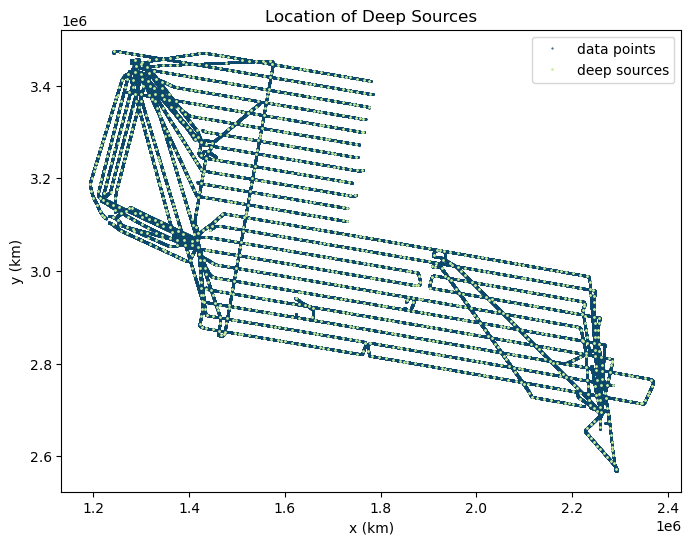

In [49]:
plt.figure(figsize=(8,6))
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#cff09e", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.legend()
plt.show()

In [50]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep = [55e3, 56e3, 57e3, 58e3, 59e3, 60e3, 61e3, 62e3, 63e3, 64e3, 65e3]#[spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep = [1e-1, 1e0, 1e1, 1e2, 1e3]#[1e0, 1e1, 1e2, 1e3, 1e4]

In [51]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 55


In [11]:
%%time
kfold = vd.BlockKFold(
    spacing=200e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction, dtype="float64"
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_blocked[test] - predicted)**2)))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 1h 43min 28s, sys: 33.5 s, total: 1h 44min 1s
Wall time: 27.6 s


In [ ]:
%%time
kfold = vd.BlockKFold(
    spacing=200e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction, dtype="float32"
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_blocked[test] - predicted)**2)))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

Best parameters: {'damping': 10.0, 'depth': 59000.0}
Best RMSE: 107.206 nT


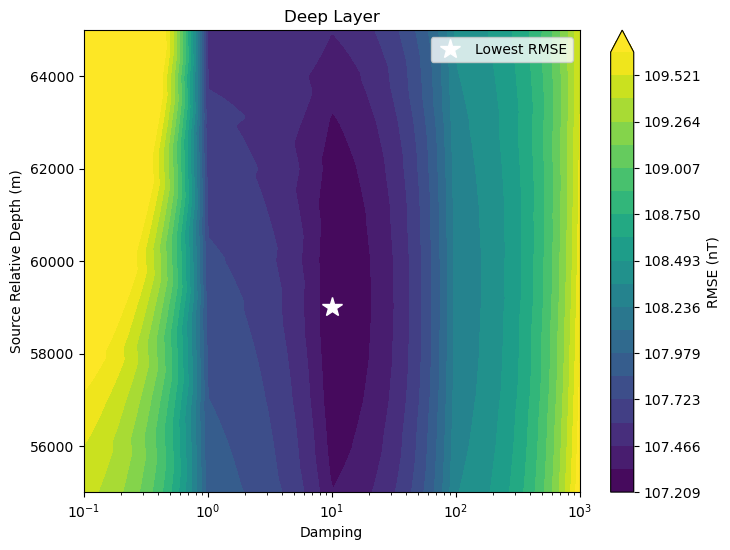

In [12]:
damping_values_deep = np.array(damping_deep)
depth_values_deep = np.array(source_depth_deep)
score_values_deep = np.array(scores_deep)

best_deep = np.argmin(score_values_deep)
best_damping_deep = damping_values_deep[best_deep]
best_depth_deep = depth_values_deep[best_deep]
best_rmse_deep = score_values_deep[best_deep]
best_params_deep = parameter_sets_deep[best_deep]
print("Best parameters:", best_params_deep)
print(f"Best RMSE: {best_rmse_deep:.3f} nT")

x_deep = np.logspace(np.log10(damping_values_deep.min()), np.log10(damping_values_deep.max()), 200)
y_deep = np.linspace(depth_values_deep.min(), depth_values_deep.max(), 200)
X_deep, Y_deep = np.meshgrid(x_deep, y_deep)
Z_deep = griddata(
    (damping_values_deep, depth_values_deep),
    score_values_deep,
    (X_deep, Y_deep),
    method='linear',
)

plt.figure(figsize=(8, 6))
levels_deep = np.linspace(
    Z_deep.min(),
    np.nanpercentile(score_values_deep, 80),
    20,
)
c = plt.contourf(
    X_deep,
    Y_deep,
    Z_deep,
    levels=levels_deep,
    cmap="viridis",
    extend='max',
)
plt.plot(
    best_damping_deep,
    best_depth_deep,
    '*',
    color='white',
    markersize=15,
    label='Lowest RMSE'
)
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Deep Layer")
plt.show()

In [52]:
# Usando parâmetros fixos com os valores ótimos encontrados, para avaliar apenas o tempo de execução.
fixed_damping = 10.0 #best_params_deep[0] 
fixed_depth = 59000.0#best_params_deep[1]   
n_repeticoes = 31 # n-1 amostras    

# Lista dos resultados
resultados_benchmark = []


# ---  64-bits ---

for i in range(n_repeticoes):

    eqs_benchmark = eqs.EquivalentSourcesMagnetic(
        damping=fixed_damping,
        depth=fixed_depth,
    )
    
    start_time = time.perf_counter()
    
    eqs_benchmark.fit(
        coords_blocked, 
        tfa_blocked, 
        field_direction,
        dtype="float64" 
    )
    
    end_time = time.perf_counter()
    
    resultados_benchmark.append({
        "Versão": "64-bits",
        "Rodada": i,
        "Duração": end_time - start_time
    })


# --- 32-bits ---

for i in range(n_repeticoes):
    # Reinicia o modelo
    eqs_benchmark = eqs.EquivalentSourcesMagnetic(
        damping=fixed_damping,
        depth=fixed_depth,
        dtype="float32" 
    )
    
    start_time = time.perf_counter()
    
    eqs_benchmark.fit(
        coords_blocked, 
        tfa_blocked, 
        field_direction,
        dtype="float32" 
    )
    
    end_time = time.perf_counter()
    
    resultados_benchmark.append({
        "Versão": "32-bits",
        "Rodada": i,
        "Duração": end_time - start_time
    })


df_resultados = pd.DataFrame(resultados_benchmark)

# Remover a primeira iteração de cada grupo 
df_resultados = df_resultados[df_resultados["Rodada"] > 0]

# Estatísticas
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())




--- Estatísticas Descritivas por Versão ---
         count      mean       std       min       25%       50%       75%  \
Versão                                                                       
32-bits   30.0  0.090321  0.001646  0.088075  0.089159  0.089771  0.091894   
64-bits   30.0  0.138497  0.002295  0.134230  0.136685  0.138273  0.140126   

              max  
Versão             
32-bits  0.093696  
64-bits  0.144079  


In [53]:
df_resultados

,Versão,Rodada,Duração
1,64-bits,1,0.137271
2,64-bits,2,0.140538
3,64-bits,3,0.137983
4,64-bits,4,0.138157
5,64-bits,5,0.136635
6,64-bits,6,0.136657
7,64-bits,7,0.138669
8,64-bits,8,0.140388
9,64-bits,9,0.136334
10,64-bits,10,0.136771


#### Plotar as estatísticas

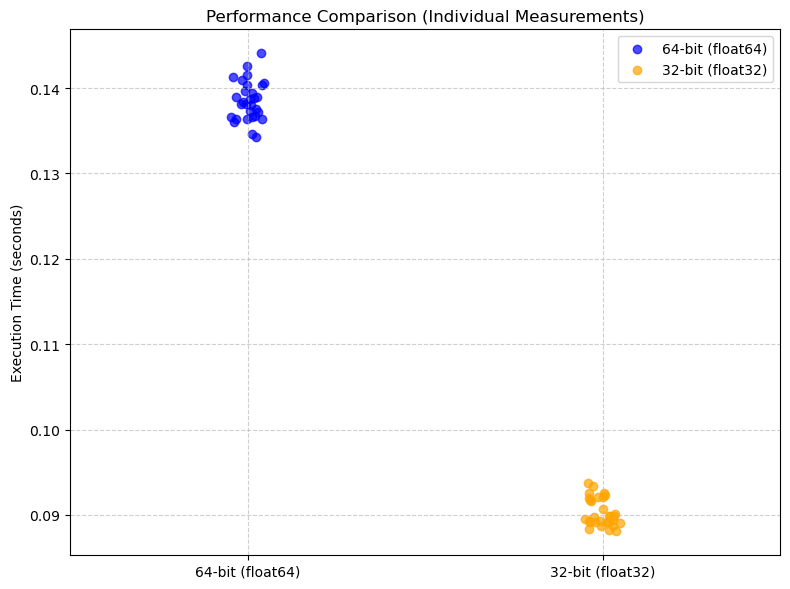

/tmp/ipykernel_1983974/2064525444.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([tempos_64bit, tempos_32bit],


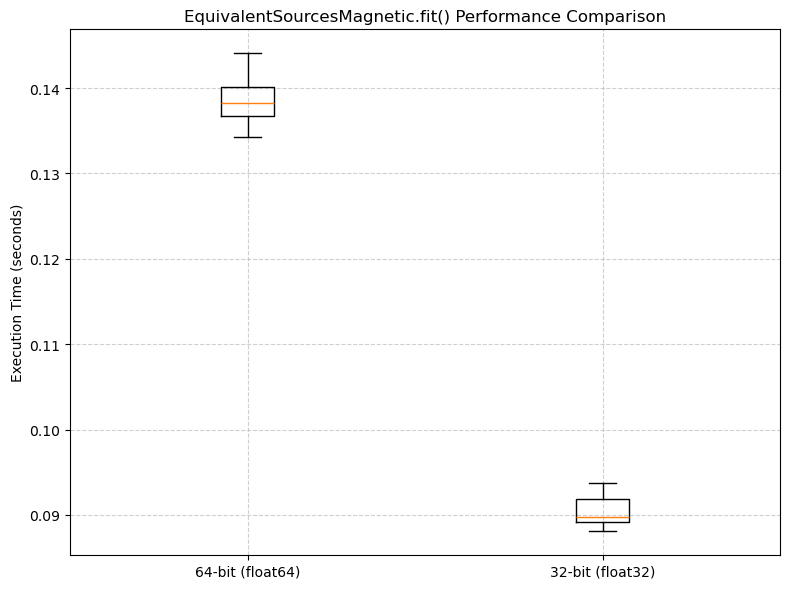

In [54]:
# --- PREPARAÇÃO DOS DADOS  ---
# Extraindo os arrays de tempo do DataFrame 'df_filtered' gerado no passo anterior
tempos_64bit = df_resultados[df_resultados["Versão"] == "64-bits"]["Duração"].values
tempos_32bit = df_resultados[df_resultados["Versão"] == "32-bits"]["Duração"].values

# --- GRÁFICO 1: SCATTER COM JITTER (SEU MODELO) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)", color='blue')
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)", color='orange')

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

# --- GRÁFICO 2: BOXPLOT (SEU MODELO) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Cria o boxplot
bp = ax.boxplot([tempos_64bit, tempos_32bit], 
                labels=["64-bit (float64)", "32-bit (float32)"]) 

ax.set_title('EquivalentSourcesMagnetic.fit() Performance Comparison')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [57]:
eqs_64 = eqs.EquivalentSourcesMagnetic(
        damping=fixed_damping,
        depth=fixed_depth
        )
    

eqs_64.fit(
        coords_blocked, 
        tfa_blocked, 
        field_direction
    )


eqs_32 = eqs.EquivalentSourcesMagnetic(
        damping=fixed_damping,
        depth=fixed_depth,
        dtype="float32" 
    )
    

eqs_32.fit(
        coords_blocked, 
        tfa_blocked, 
        field_direction,
        dtype="float32" 
    )


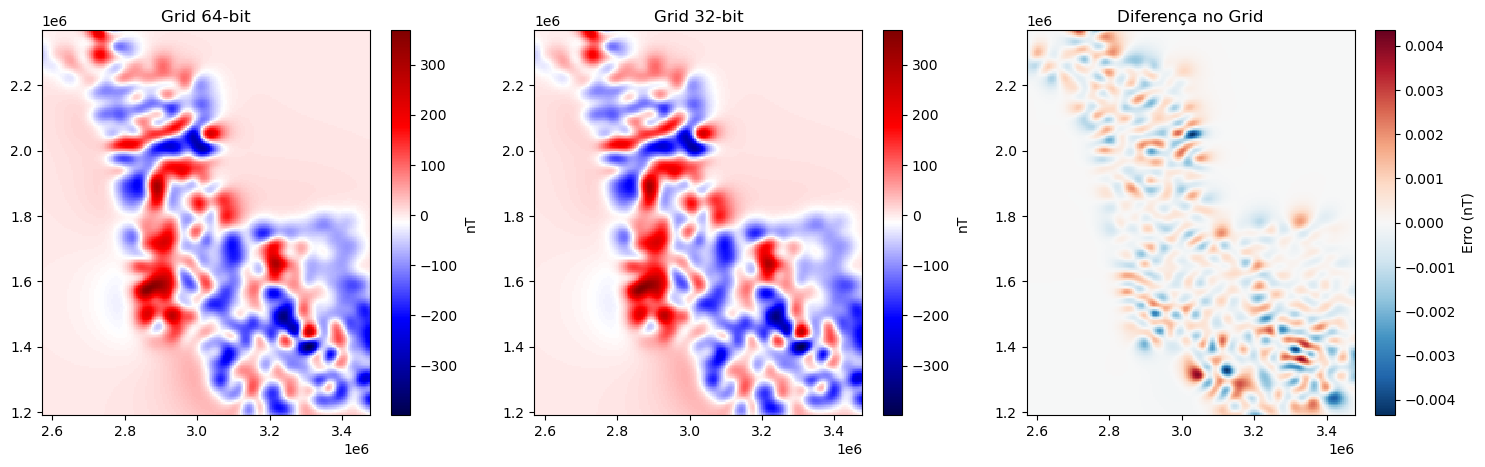

In [58]:
region_grid = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region_deep,
    spacing=5e3,       
    extra_coords=3000 
)


pred_vec_64 = eqs_64.predict(grid_coords)
pred_vec_32 = eqs_32.predict(grid_coords)

# --- 3. Calcular o Total field anomaly ---
# Projetamos os vetores na direção do campo da Terra
tfa_64_flat = eqs.total_field_anomaly(pred_vec_64, field_direction)
tfa_32_flat = eqs.total_field_anomaly(pred_vec_32, field_direction)

# --- 4. Diferença (Erro no Grid) ---
diff_grid_flat = tfa_64_flat - tfa_32_flat

# --- 5. Plotagem (O Segredo do Pcolormesh) ---
# O plt.pcolormesh precisa das coordenadas em formato de GRADE (2D).
# O vd.grid_coordinates já devolve assim no item [0] e [1].
# Mas o resultado do predict/tfa geralmente vem achatado (1D). 
# Precisamos garantir que o TFA tenha o mesmo shape das coordenadas.

shape_grid = grid_coords[0].shape # Pega o formato (Linhas, Colunas)

# Remodelamos os dados para 2D
tfa_64_grid = tfa_64_flat.reshape(shape_grid)
tfa_32_grid = tfa_32_flat.reshape(shape_grid)
diff_grid   = diff_grid_flat.reshape(shape_grid)

# Agora plotamos
plt.figure(figsize=(18, 5))

# Grid 64
plt.subplot(1, 3, 1)
plt.pcolormesh(grid_coords[1], grid_coords[0], tfa_64_grid, cmap="seismic", shading='auto')
plt.colorbar(label="nT")
plt.title("Grid 64-bit")

#Grid 32
plt.subplot(1, 3, 2)
plt.pcolormesh(grid_coords[1], grid_coords[0], tfa_32_grid, cmap="seismic", shading='auto')
plt.colorbar(label="nT")
plt.title("Grid 32-bit")

# Diferença
plt.subplot(1, 3, 3)
scale = np.max(np.abs(diff_grid))
plt.pcolormesh(grid_coords[1], grid_coords[0], diff_grid, cmap="RdBu_r", vmin=-scale, vmax=scale, shading='auto')
plt.colorbar(label="Erro (nT)")
plt.title("Diferença no Grid")

plt.show()

In [59]:
# Extraindo os valores dos grids (usando o nome "grid" que você definiu no data_names)
valores_64 = tfa_64_flat
valores_32 = tfa_32_flat

# Cálculo do MSE
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids é: {mse}")

# Cálculo do RMSE
rmse = np.sqrt(mse)

# Unidade alterada para nT (nanotesla)
print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

# Erro relativo à média dos valores absolutos
media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

# Erro relativo à amplitude total dos dados
amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids é: 3.18476873137065e-07
A Raiz do Erro Quadrático Médio (RMSE) é: 0.0006 nT
O erro dividido pela média dos valores absolutos dos dados é: 1.3302052659964135e-05
O erro relativo à amplitude dos dados é: 7.356852262679904e-07


In [17]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav.MagL - tfa_deep

source height: -56113.1
CPU times: user 47.4 s, sys: 37.2 ms, total: 47.4 s
Wall time: 249 ms


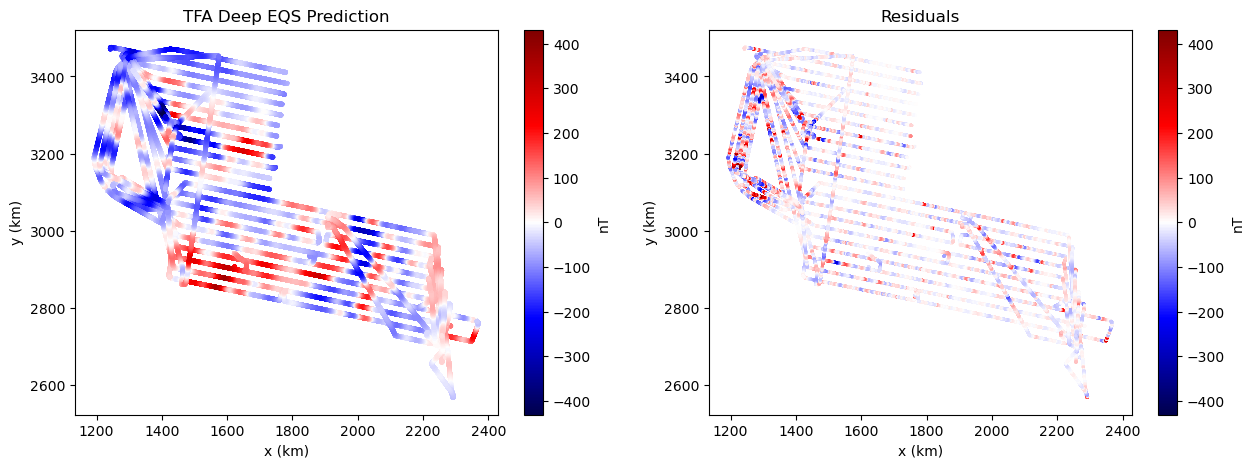

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates_km[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
#scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates_km[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with the shallow GB EQS layer

In [16]:
window_size = 400e3
dampings_shallow = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
depths_shallow = [9e3, 10e3, 11e3, 12e3, 13e3] #[5e3, 10e3, 15e3, 20e3, 25e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 30


In [16]:
%%time
kfold = vd.BlockKFold(
    spacing=20e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow_64 = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_residuals[test] - predicted)**2)))
    scores_shallow_64.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 9000.0}
{'damping': 1.0, 'depth': 10000.0}
{'damping': 1.0, 'depth': 11000.0}
{'damping': 1.0, 'depth': 12000.0}
{'damping': 1.0, 'depth': 13000.0}
{'damping': 10.0, 'depth': 9000.0}
{'damping': 10.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 11000.0}
{'damping': 10.0, 'depth': 12000.0}
{'damping': 10.0, 'depth': 13000.0}
{'damping': 100.0, 'depth': 9000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 11000.0}
{'damping': 100.0, 'depth': 12000.0}
{'damping': 100.0, 'depth': 13000.0}
{'damping': 1000.0, 'depth': 9000.0}
{'damping': 1000.0, 'depth': 10000.0}
{'damping': 1000.0, 'depth': 11000.0}
{'damping': 1000.0, 'depth': 12000.0}
{'damping': 1000.0, 'depth': 13000.0}
{'damping': 10000.0, 'depth': 9000.0}
{'damping': 10000.0, 'depth': 10000.0}
{'damping': 10000.0, 'depth': 11000.0}
{'damping': 10000.0, 'depth': 12000.0}
{'damping': 10000.0, 'depth': 13000.0}
{'damping': 100000.0, 'depth': 9000.0}
{'damping': 100000.0, 'depth': 10000.0}
{

In [17]:
%%time
kfold = vd.BlockKFold(
    spacing=20e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow_32 = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
            dtype="float32"
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_residuals[test] - predicted)**2)))
    scores_shallow_32.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 9000.0}
{'damping': 1.0, 'depth': 10000.0}
{'damping': 1.0, 'depth': 11000.0}
{'damping': 1.0, 'depth': 12000.0}
{'damping': 1.0, 'depth': 13000.0}
{'damping': 10.0, 'depth': 9000.0}
{'damping': 10.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 11000.0}
{'damping': 10.0, 'depth': 12000.0}
{'damping': 10.0, 'depth': 13000.0}
{'damping': 100.0, 'depth': 9000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 11000.0}
{'damping': 100.0, 'depth': 12000.0}
{'damping': 100.0, 'depth': 13000.0}
{'damping': 1000.0, 'depth': 9000.0}
{'damping': 1000.0, 'depth': 10000.0}
{'damping': 1000.0, 'depth': 11000.0}
{'damping': 1000.0, 'depth': 12000.0}
{'damping': 1000.0, 'depth': 13000.0}
{'damping': 10000.0, 'depth': 9000.0}
{'damping': 10000.0, 'depth': 10000.0}
{'damping': 10000.0, 'depth': 11000.0}
{'damping': 10000.0, 'depth': 12000.0}
{'damping': 10000.0, 'depth': 13000.0}
{'damping': 100000.0, 'depth': 9000.0}
{'damping': 100000.0, 'depth': 10000.0}
{

#### Averiguando as respostas dos métodos 

--- Tabela Comparativa (Amostra) ---
   Damping    Depth   Score_64   Score_32  Diff_Abs  Erro_Relativo_%
0      1.0   9000.0  52.978471  52.978105  0.000366         0.000690
1      1.0  10000.0  52.990933  52.990012  0.000921         0.001738
2      1.0  11000.0  53.349897  53.349426  0.000471         0.000883
3      1.0  12000.0  54.040170  54.022743  0.017428         0.032249
4      1.0  13000.0  55.192737  55.193632 -0.000895         0.001621

--- Veredito da Otimização ---
Melhor Configuração (64-bit): Damping=100.0, Depth=11000.0 (Score: 51.6723)
Melhor Configuração (32-bit): Damping=100.0, Depth=11000.0 (Score: 51.6702)
✅ SUCESSO: Ambas as versões escolheram os mesmos parâmetros ideais.


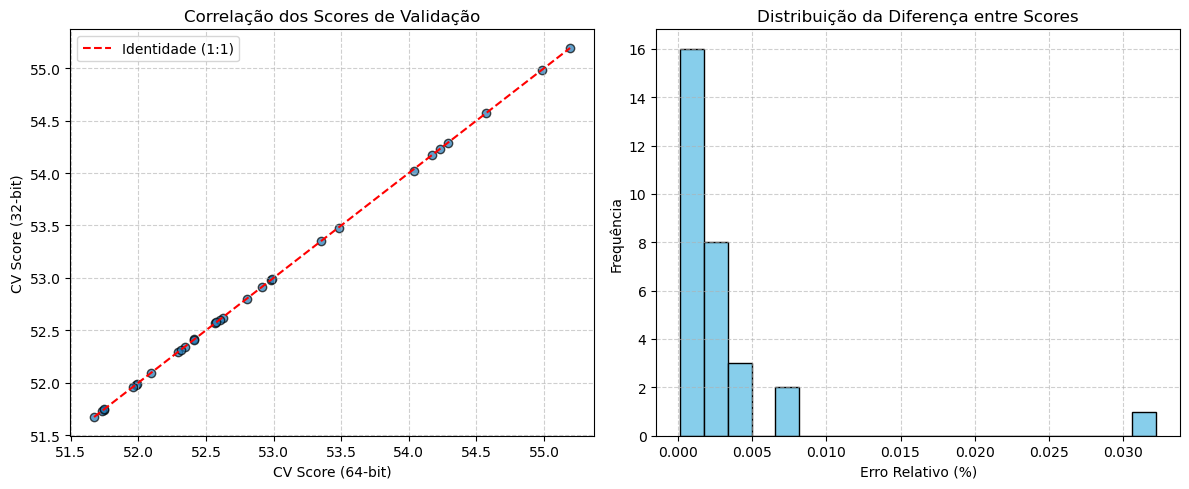

In [18]:

# 1. Criar um DataFrame para organizar os dados lado a lado
df_cv = pd.DataFrame({
    'Damping': damping_shallow,
    'Depth': source_depth_shallow,
    'Score_64': scores_shallow_64,
    'Score_32': scores_shallow_32
})

# 2. Calcular a diferença relativa entre as notas (scores)
# O score aqui é o RMSE médio das dobras (folds)
df_cv['Diff_Abs'] = np.abs(df_cv['Score_64'] - df_cv['Score_32'])
df_cv['Erro_Relativo_%'] = np.abs((df_cv['Score_64'] - df_cv['Score_32']) / df_cv['Score_64']) * 100

print("--- Tabela Comparativa (Amostra) ---")
print(df_cv.head())

# 3. Verificar o "Vencedor" 
# O objetivo do CV é achar o MENOR score. Vamos ver se os dois concordam quem é o melhor.
idx_melhor_64 = df_cv['Score_64'].idxmin()
idx_melhor_32 = df_cv['Score_32'].idxmin()

melhor_param_64 = df_cv.loc[idx_melhor_64]
melhor_param_32 = df_cv.loc[idx_melhor_32]

print("\n--- Veredito da Otimização ---")
print(f"Melhor Configuração (64-bit): Damping={melhor_param_64['Damping']}, Depth={melhor_param_64['Depth']} (Score: {melhor_param_64['Score_64']:.4f})")
print(f"Melhor Configuração (32-bit): Damping={melhor_param_32['Damping']}, Depth={melhor_param_32['Depth']} (Score: {melhor_param_32['Score_32']:.4f})")

if idx_melhor_64 == idx_melhor_32:
    print("SUCESSO: Ambas as versões escolheram os mesmos parâmetros ideais.")
else:
    print("ALERTA: As versões escolheram parâmetros diferentes! A precisão afetou a decisão do modelo.")

# 4. Visualização Gráfica
plt.figure(figsize=(12, 5))

# Gráfico 1: Correlação direta
plt.subplot(1, 2, 1)
plt.scatter(df_cv['Score_64'], df_cv['Score_32'], alpha=0.7, edgecolors='k')
plt.plot([df_cv['Score_64'].min(), df_cv['Score_64'].max()], 
         [df_cv['Score_64'].min(), df_cv['Score_64'].max()], 'r--', label='Identidade (1:1)')
plt.xlabel('CV Score (64-bit)')
plt.ylabel('CV Score (32-bit)')
plt.title('Correlação dos Scores de Validação')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Erro Relativo
plt.subplot(1, 2, 2)
plt.hist(df_cv['Erro_Relativo_%'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Erro Relativo (%)')
plt.ylabel('Frequência')
plt.title('Distribuição da Diferença entre Scores')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Best parameters: {'damping': 100.0, 'depth': 11000.0}
Best RMSE: 51.672 nT


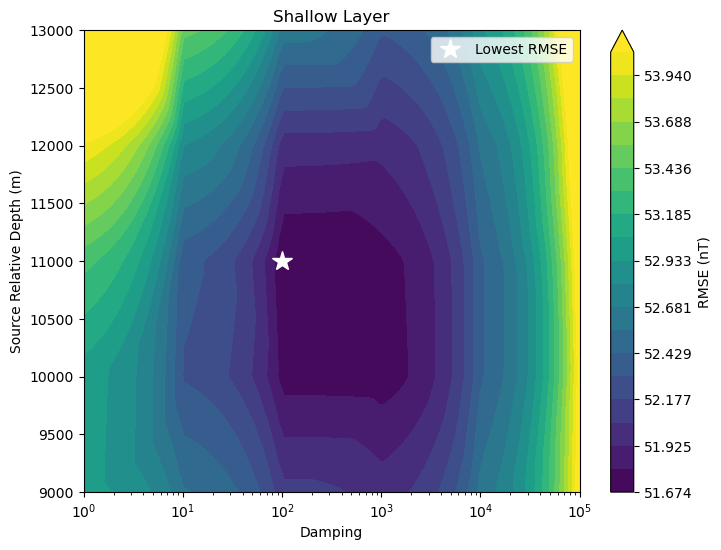

In [19]:
damping_values_shallow = np.array(damping_shallow)
depth_values_shallow = np.array(source_depth_shallow)
score_values_shallow = np.array(scores_shallow_64)

best_shallow = np.argmin(score_values_shallow)
best_damping_shallow = damping_values_shallow[best_shallow]
best_depth_shallow = depth_values_shallow[best_shallow]
best_rmse_shallow = score_values_shallow[best_shallow]
best_params_shallow = parameter_sets_shallow[best_shallow]
print("Best parameters:", best_params_shallow)
print(f"Best RMSE: {best_rmse_shallow:.3f} nT")

x_shallow = np.logspace(np.log10(damping_values_shallow.min()), np.log10(damping_values_shallow.max()), 100)
y_shallow = np.linspace(depth_values_shallow.min(), depth_values_shallow.max(), 100)
X_shallow, Y_shallow = np.meshgrid(x_shallow, y_shallow)

Z_shallow = griddata(
    (damping_values_shallow, depth_values_shallow),
    score_values_shallow,
    (X_shallow, Y_shallow),
    method='linear'
)
plt.figure(figsize=(8, 6))
levels_shallow = np.linspace(
    Z_shallow.min(),
    np.nanpercentile(score_values_shallow, 80),
    20,
)
c = plt.contourf(
    X_shallow,
    Y_shallow,
    Z_shallow,
    levels=levels_shallow,
    cmap="viridis",
    extend='max',
)
plt.plot(
    best_damping_shallow,
    best_depth_shallow,
    '*',
    color='white',
    markersize=15,
    label='Lowest RMSE'
)
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Shallow Layer")
plt.show()

In [19]:
# Usando parâmetros fixos com os valores ótimos encontrados, para avaliar apenas o tempo de execução.
fixed_damping = 100.0 #best_params_deep[0] 
fixed_depth = 11000.0#best_params_deep[1]   
n_repeticoes = 31 # n-1 amostras    

# Lista dos resultados
resultados_benchmark = []


# ---  64-bits ---

for i in range(n_repeticoes):

    eqs_benchmark = eqs.EquivalentSourcesMagneticGB(
        random_state=i, # Mudamos a seed a cada rodada para variar o Gradient Boosting
        block_size=grid_spacing,
        window_size=window_size,
        damping=fixed_damping,
        depth=fixed_depth,
        dtype="float64"
    )
    
    start_time = time.perf_counter()
    
    eqs_benchmark.fit(
        coordinates, 
        tfa_residuals, 
        field_direction,
        dtype="float64" 
    )
    
    end_time = time.perf_counter()
    
    resultados_benchmark.append({
        "Versão": "64-bits",
        "Rodada": i,
        "Duração": end_time - start_time
    })


# --- 32-bits ---

for i in range(n_repeticoes):
    # Reinicia o modelo
    eqs_benchmark = eqs.EquivalentSourcesMagneticGB(
        random_state=i,
        block_size=grid_spacing,
        window_size=window_size,
        damping=fixed_damping,
        depth=fixed_depth,
        dtype="float32" 
    )
    
    start_time = time.perf_counter()
    
    eqs_benchmark.fit(
        coordinates, 
        tfa_residuals, 
        field_direction,
        dtype="float32" 
    )
    
    end_time = time.perf_counter()
    
    resultados_benchmark.append({
        "Versão": "32-bits",
        "Rodada": i,
        "Duração": end_time - start_time
    })


df_resultados = pd.DataFrame(resultados_benchmark)

# Remover a primeira iteração de cada grupo 
df_resultados = df_resultados[df_resultados["Rodada"] > 0]

# Estatísticas
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())





--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32-bits   30.0  35.842571  0.075739  35.694934  35.805681  35.849341   
64-bits   30.0  60.174373  0.083529  60.035086  60.135731  60.159326   

               75%        max  
Versão                         
32-bits  35.882823  36.041391  
64-bits  60.204572  60.444315  


In [31]:
df_resultados

,Versão,Rodada,Duração
1,64-bits,1,60.156088
2,64-bits,2,60.244521
3,64-bits,3,60.092789
4,64-bits,4,60.235671
5,64-bits,5,60.444315
6,64-bits,6,60.173305
7,64-bits,7,60.350960
8,64-bits,8,60.081741
9,64-bits,9,60.145327
10,64-bits,10,60.165096


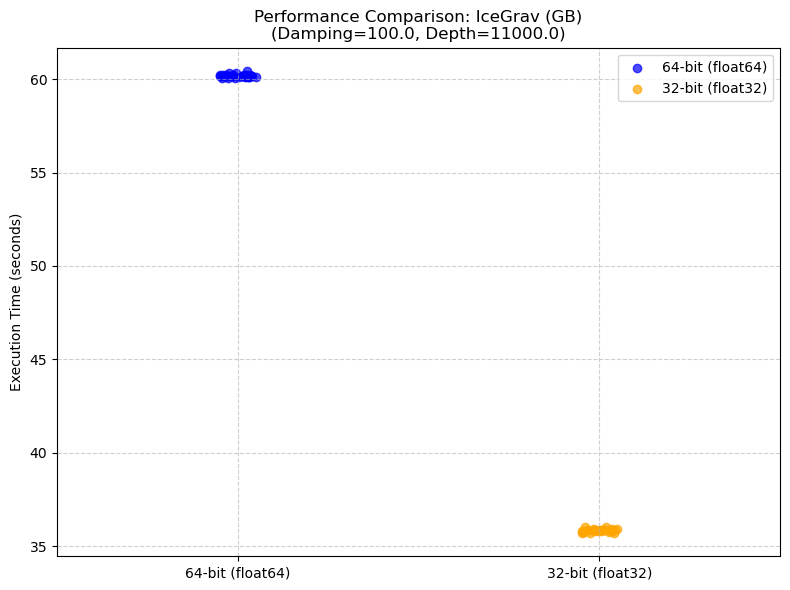

/tmp/ipykernel_1983974/3021073347.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([tempos_64bit, tempos_32bit],


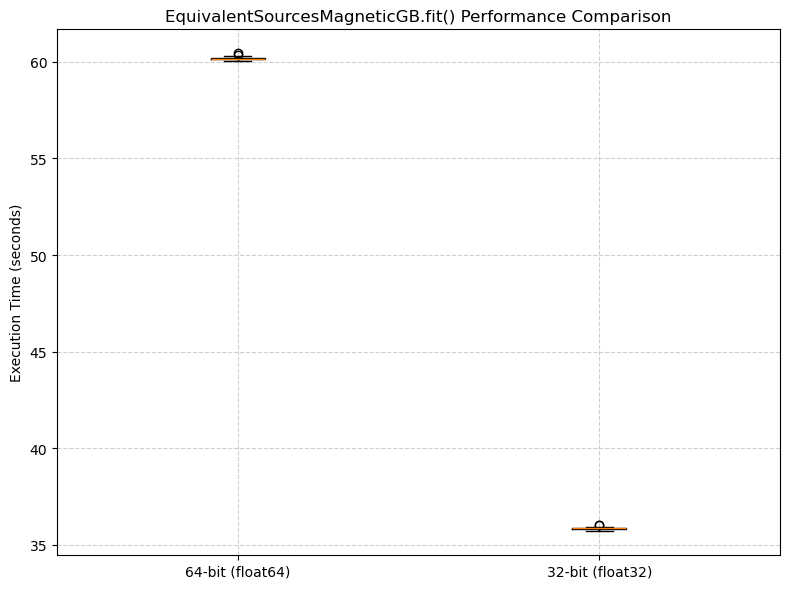

In [23]:
# --- PREPARAÇÃO DOS DADOS  ---
# Extraindo os arrays de tempo do DataFrame 'df_filtered' gerado no passo anterior
tempos_64bit = df_resultados[df_resultados["Versão"] == "64-bits"]["Duração"].values
tempos_32bit = df_resultados[df_resultados["Versão"] == "32-bits"]["Duração"].values

# --- GRÁFICO 1: SCATTER COM JITTER (SEU MODELO) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)", color='blue')
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)", color='orange')

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title(f'Performance Comparison: IceGrav (GB)\n(Damping={fixed_damping}, Depth={fixed_depth})')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

# --- GRÁFICO 2: BOXPLOT (SEU MODELO) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Cria o boxplot
bp = ax.boxplot([tempos_64bit, tempos_32bit], 
                labels=["64-bit (float64)", "32-bit (float32)"]) # patch_artist permite colorir


ax.set_title('EquivalentSourcesMagneticGB.fit() Performance Comparison')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [28]:
eqs_64 = eqs.EquivalentSourcesMagneticGB(
        random_state=0,
        block_size=grid_spacing,
        window_size=window_size,
        damping=fixed_damping,
        depth=fixed_depth
        )
    

eqs_64.fit(
        coordinates, 
        tfa_residuals, 
        field_direction
    )


eqs_32 = eqs.EquivalentSourcesMagneticGB(
        random_state=0,
        block_size=grid_spacing,
        window_size=window_size,
        damping=fixed_damping,
        depth=fixed_depth,
        dtype="float32" 
    )
    

eqs_32.fit(
        coordinates, 
        tfa_residuals, 
        field_direction,
        dtype="float32" 
    )

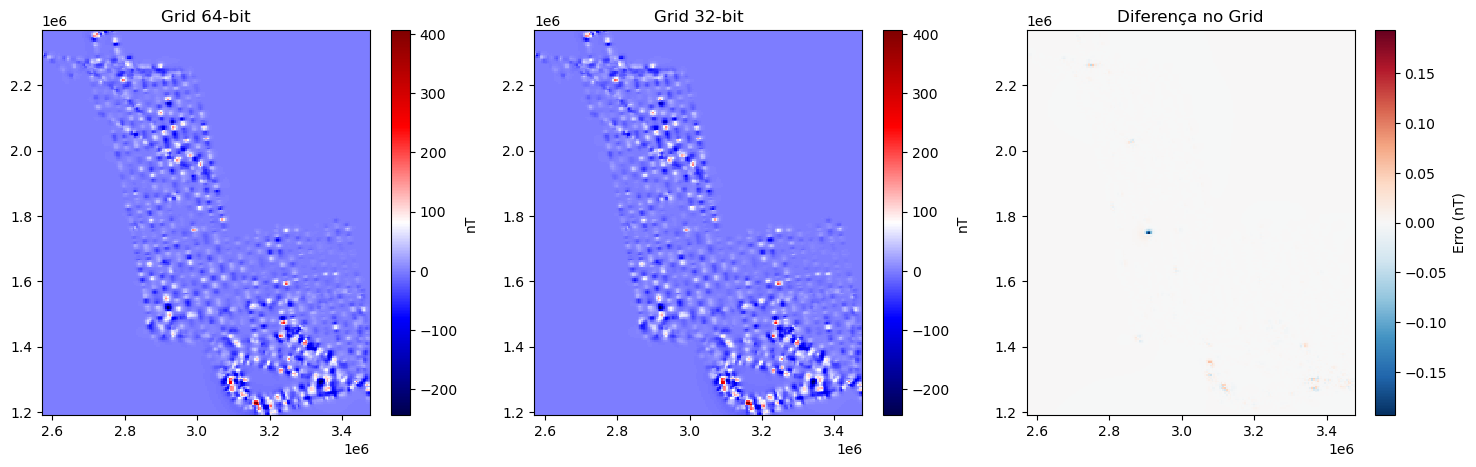

In [35]:
region_grid = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region_deep,
    spacing=5e3,       
    extra_coords=3000 
)


pred_vec_64 = eqs_64.predict(grid_coords)
pred_vec_32 = eqs_32.predict(grid_coords)

# --- 3. Calcular o Total field anomaly ---
# Projetamos os vetores na direção do campo da Terra
tfa_64_flat = eqs.total_field_anomaly(pred_vec_64, field_direction)
tfa_32_flat = eqs.total_field_anomaly(pred_vec_32, field_direction)

# --- 4. Diferença (Erro no Grid) ---
diff_grid_flat = tfa_64_flat - tfa_32_flat

# --- 5. Plotagem (O Segredo do Pcolormesh) ---
# O plt.pcolormesh precisa das coordenadas em formato de GRADE (2D).
# O vd.grid_coordinates já devolve assim no item [0] e [1].
# Mas o resultado do predict/tfa geralmente vem achatado (1D). 
# Precisamos garantir que o TFA tenha o mesmo shape das coordenadas.

shape_grid = grid_coords[0].shape # Pega o formato (Linhas, Colunas)

# Remodelamos os dados para 2D
tfa_64_grid = tfa_64_flat.reshape(shape_grid)
tfa_32_grid = tfa_32_flat.reshape(shape_grid)
diff_grid   = diff_grid_flat.reshape(shape_grid)

# Agora plotamos
plt.figure(figsize=(18, 5))

# Grid 64
plt.subplot(1, 3, 1)
plt.pcolormesh(grid_coords[1], grid_coords[0], tfa_64_grid, cmap="seismic", shading='auto')
plt.colorbar(label="nT")
plt.title("Grid 64-bit")

#Grid 32
plt.subplot(1, 3, 2)
plt.pcolormesh(grid_coords[1], grid_coords[0], tfa_32_grid, cmap="seismic", shading='auto')
plt.colorbar(label="nT")
plt.title("Grid 32-bit")

# Diferença
plt.subplot(1, 3, 3)
scale = np.max(np.abs(diff_grid))
plt.pcolormesh(grid_coords[1], grid_coords[0], diff_grid, cmap="RdBu_r", vmin=-scale, vmax=scale, shading='auto')
plt.colorbar(label="Erro (nT)")
plt.title("Diferença no Grid")

plt.show()

In [42]:
# Extraindo os valores dos grids (usando o nome "grid" que você definiu no data_names)
valores_64 = tfa_64_flat
valores_32 = tfa_32_flat

# Cálculo do MSE
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids é: {mse}")

# Cálculo do RMSE
rmse = np.sqrt(mse)

# Unidade alterada para nT (nanotesla)
print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

# Erro relativo à média dos valores absolutos
media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

# Erro relativo à amplitude total dos dados
amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids é: 5.340454228274102e-06
A Raiz do Erro Quadrático Médio (RMSE) é: 0.0023 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.00035410153902363514
O erro relativo à amplitude dos dados é: 3.5571900804055166e-06


In [25]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

NameError: name 'best_shallow' is not defined

In [21]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction, dtype="float32")

CPU times: user 24min 8s, sys: 18.8 s, total: 24min 26s
Wall time: 1min 11s


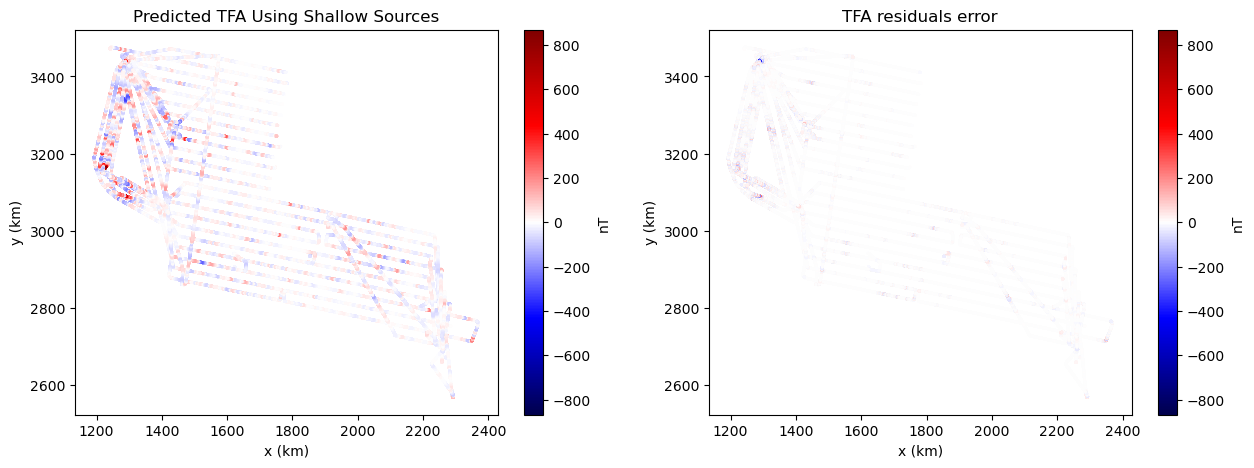

In [22]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted

plt.figure(figsize=(15,5))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates_km[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates_km[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("TFA residuals error")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Prediction

In [23]:
%%time
predicted_b = eqs_deep.predict(coordinates) + eqs_shallow.predict(coordinates)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = icegrav.MagL - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))
nrmse_tfa = rmse_tfa / (np.nanmax(icegrav.MagL) - np.nanmin(icegrav.MagL))

predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))

CPU times: user 1min 34s, sys: 952 ms, total: 1min 35s
Wall time: 301 ms


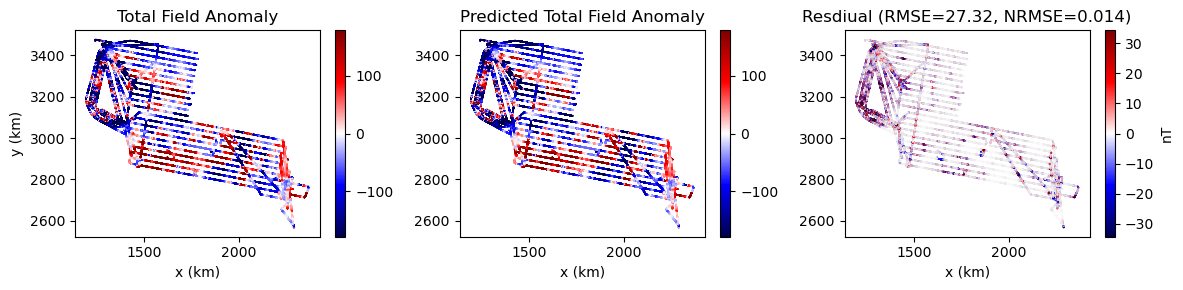

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
plot1 = ax[0].scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[0].set_title("Total Field Anomaly")
ax[0].set_ylabel("y (km)")
ax[0].set_xlabel("x (km)")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].scatter(
    *coordinates_km[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[1].set_title("Predicted Total Field Anomaly")
ax[1].set_xlabel("x (km)")
fig.colorbar(plot2, ax=ax[1])

scale_error_tfa = vd.maxabs(error_tfa) 
scale_error_tfa = np.nanpercentile(error_tfa, 99)
plot3 = ax[2].scatter(
    *coordinates_km[:2],
    c=error_tfa,
    cmap="seismic",
    s=0.001,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
ax[2].set_title(f'Resdiual (RMSE={np.round(rmse_tfa,2)}, NRMSE={np.round(nrmse_tfa, 3)})')
ax[2].set_xlabel("x (km)")
fig.colorbar(plot3, ax=ax[2], label="nT")

fig.tight_layout()
fig.show()

### Show a profile line

In [25]:
test = icegrav
test['predicted_tfa'] = predicted_tfa
flight_12 = test[test['Flight_ID'] == 12]
flight_12 = flight_12[flight_12['y'] <= 2.96e6]
flight_12 = flight_12[flight_12['y'] >= 2.81e6]
coords_flight12 = [flight_12.x, flight_12.y, flight_12.Height_WGS1984]
coords_flight12_km = [coord / 1000 for coord in coords_flight12]

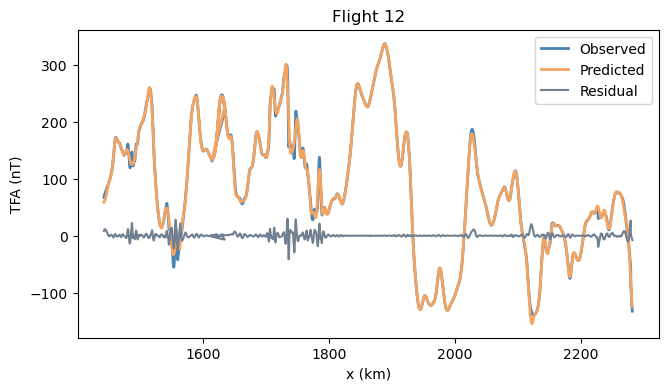

In [26]:
flight12_residuals = flight_12.MagL - flight_12.predicted_tfa

plt.figure(figsize=(7.5,4))
plt.plot(coords_flight12_km[0], flight_12.MagL, color='steelblue',label='Observed', linewidth=2)
plt.plot(coords_flight12_km[0], flight_12.predicted_tfa, color='sandybrown', label='Predicted', linewidth=2)
plt.plot(coords_flight12_km[0], flight12_residuals, color='slategrey', label='Residual', linewidth=1.5)
plt.title("Flight 12")
plt.xlabel("x (km)")
plt.ylabel("TFA (nT)")
plt.legend()
plt.show()

In [27]:
import matplotlib.colors as mcolors
# Define a custom colormap similar to the red portion of the seismic colour scheme for the norm of b figures.
colours = [(1, 1, 1), (1, 0.3, 0.3), (1, 0, 0), (0.5, 0, 0)]  # White -> bright light red -> bright red -> dark red
n_bins = 100  
red_cm = mcolors.LinearSegmentedColormap.from_list("white_to_red", colours, N=n_bins)
red_norm = mcolors.Normalize(vmin=0, vmax=np.nanpercentile(predicted_bnorm_grid, 99))# Normalise with the bnorm range

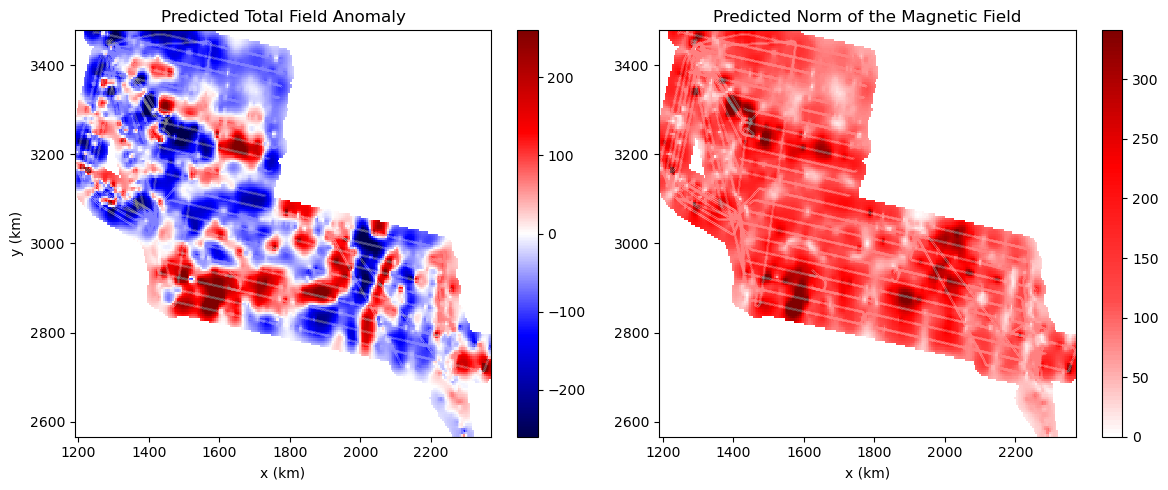

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
#scale_predicted_tfa_grid = vd.maxabs(predicted_tfa_grid)
scale_predicted_tfa_grid = np.nanpercentile(predicted_tfa_grid, 99)
plot1 = ax[0].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid,
    #cmap="jet",#"seismic",
    cmap="seismic",    
    #cmap="RdBu_r",
    vmin=-scale_predicted_tfa_grid,
    vmax=scale_predicted_tfa_grid,
)
ax[0].set_title("Predicted Total Field Anomaly")
ax[0].set_xlabel("x (km)")
ax[0].set_ylabel("y (km)")
fig.colorbar(plot1, ax=ax[0])
plot1 = ax[0].plot(
    *coordinates_km[:2],
    'w.',
    markersize=0.01,
)

plot2 = ax[1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid,
    cmap=red_cm,
    norm=red_norm,
)
ax[1].set_title("Predicted Norm of the Magnetic Field")
ax[1].set_xlabel("x (km)")
fig.colorbar(plot2, ax=ax[1])
plot2 = ax[1].plot(
    *coordinates_km[:2],
    'w.',
    markersize=0.01,
)
fig.tight_layout()
fig.show()

## Figures for paper

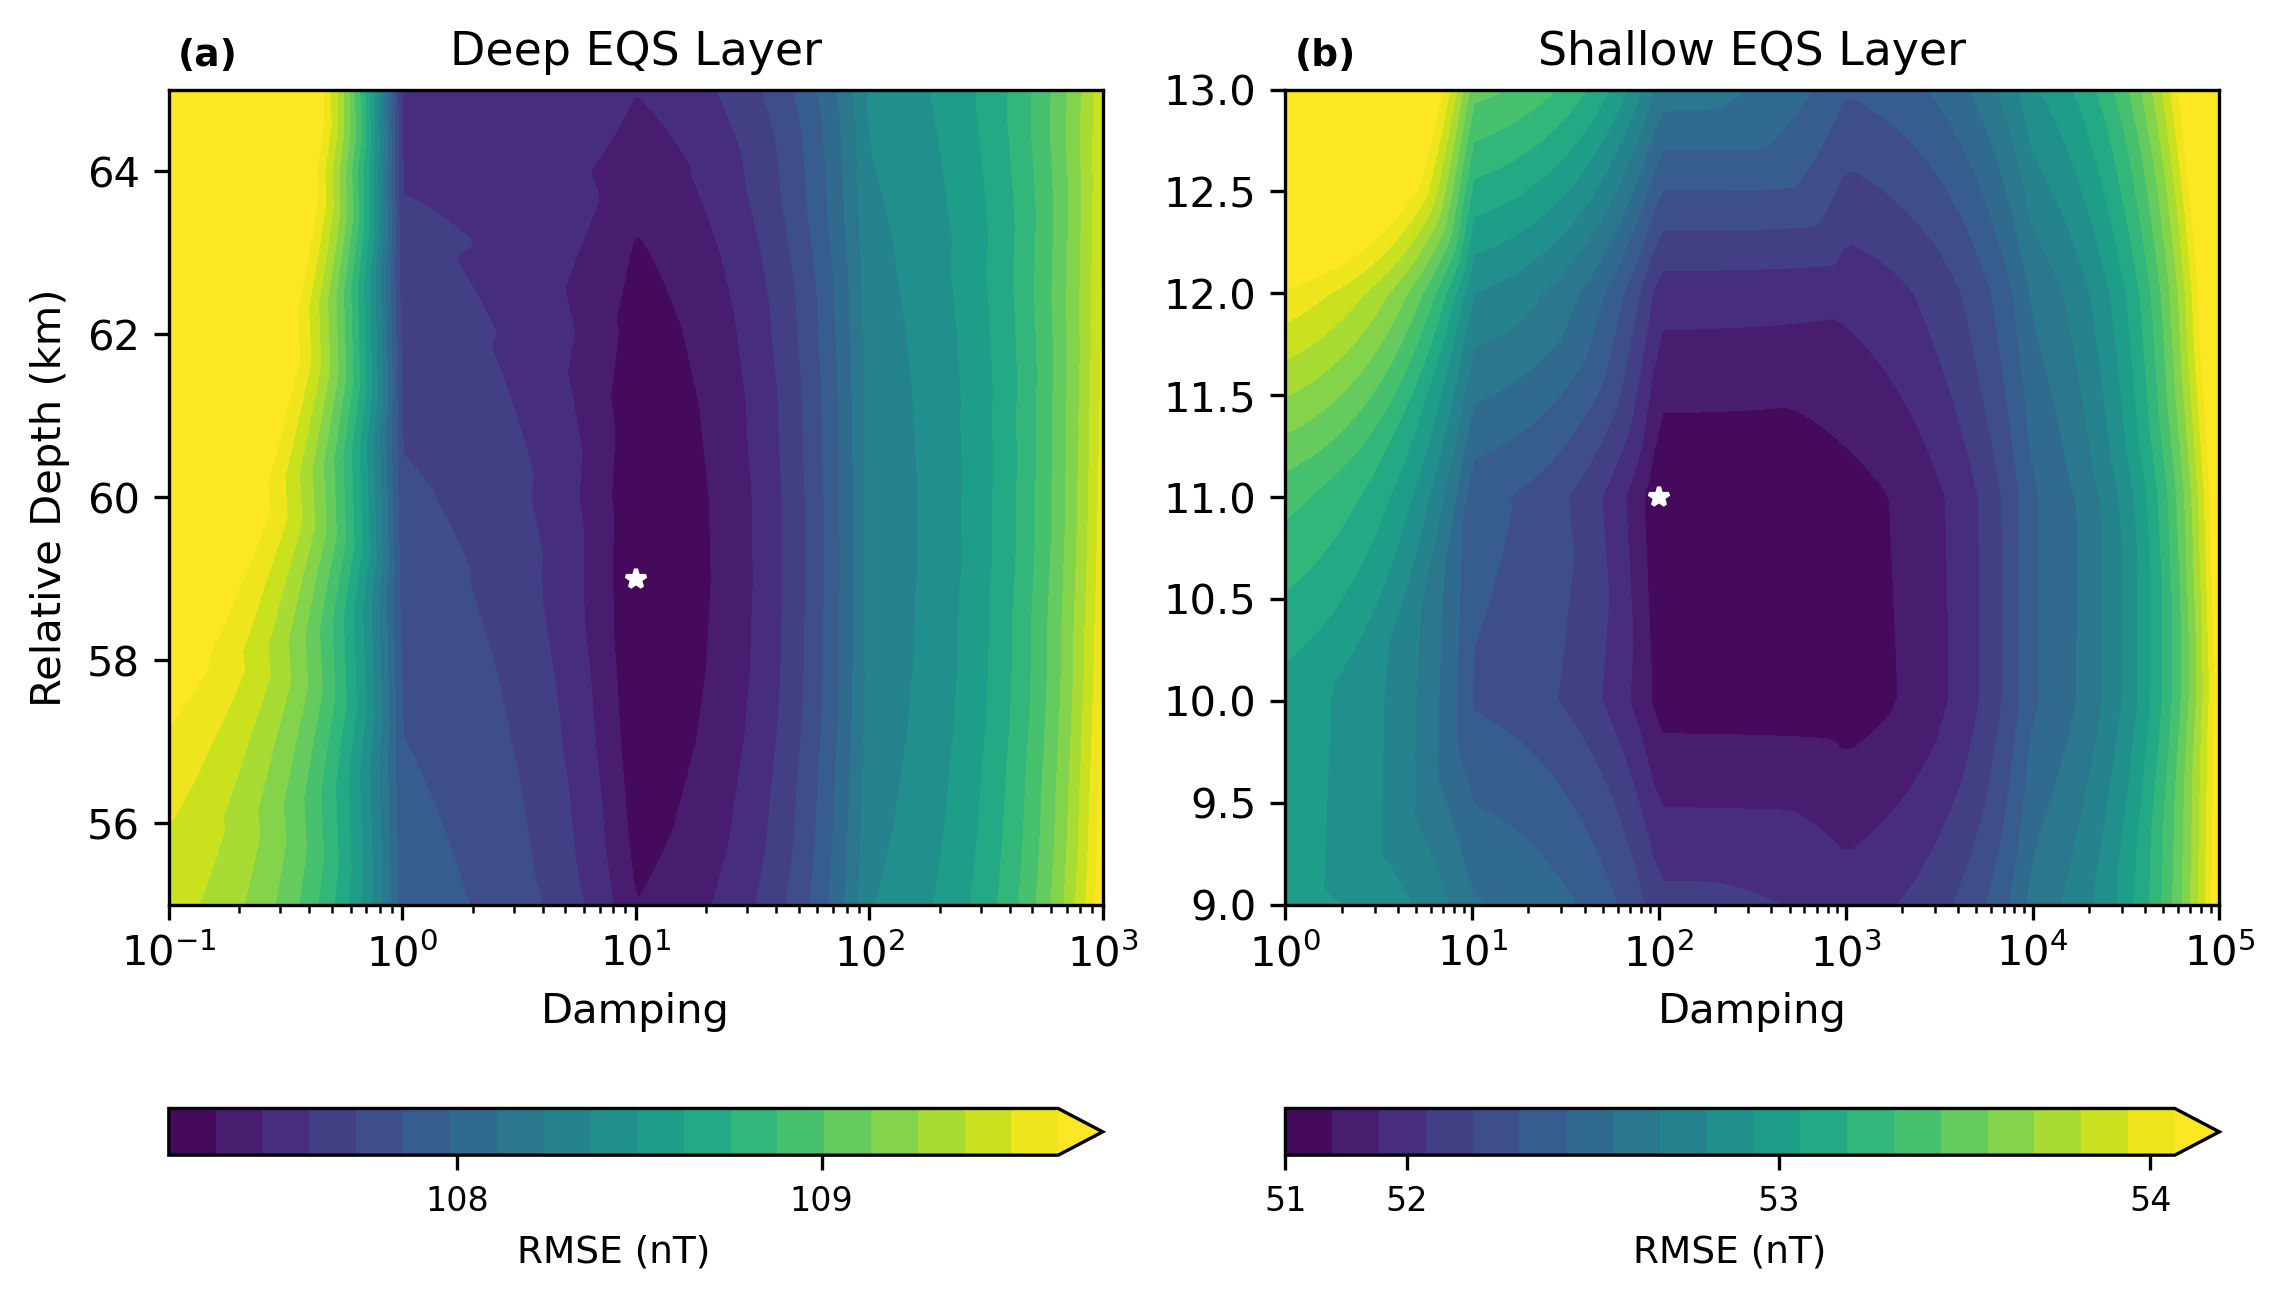

In [29]:
Y_deep_km = [depth / 1000 for depth in Y_deep]
Y_shallow_km = [depth / 1000 for depth in Y_shallow]

fig, axes = plt.subplots(1, 2, figsize=(7.5, 4.2), layout="constrained")

plot1 = axes[0].contourf(
    X_deep,
    Y_deep_km,
    Z_deep,
    levels=levels_deep,
    cmap="viridis",
    extend='max',
)
axes[0].plot(best_damping_deep, best_depth_deep/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[0].set_xscale('log')
axes[0].set_xlabel('Damping', fontsize=10)
axes[0].set_ylabel('Relative Depth (km)', fontsize=10)
axes[0].set_title("Deep EQS Layer", fontsize=11)
axes[0].text(0.01, 1.03, '(a)', transform=axes[0].transAxes, fontsize=9, fontweight='bold')
cbar1 = fig.colorbar(plot1, ax=axes[0], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar1.set_label('RMSE (nT)', fontsize=9)
cbar1.set_ticks(np.arange(int(levels_deep.min())+1, int(levels_deep.max()+1), 1))
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plot2 = axes[1].contourf(
    X_shallow,
    Y_shallow_km,
    Z_shallow,
    levels=levels_shallow,
    cmap="viridis",
    extend='max',
)
axes[1].plot(best_damping_shallow, best_depth_shallow/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[1].set_xscale('log')
axes[1].set_xlabel('Damping', fontsize=10)
axes[1].set_title("Shallow EQS Layer", fontsize=11)
axes[1].text(0.01, 1.03, '(b)', transform=axes[1].transAxes, fontsize=9, fontweight='bold')
cbar2 = fig.colorbar(plot2, ax=axes[1], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar2.set_label('RMSE (nT)', fontsize=9)
cbar2.set_ticks(np.arange(int(levels_shallow.min()), int(levels_shallow.max()+1), 1))
cbar2.ax.tick_params(labelsize=8)
cbar2.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# plt.show()
cv_real_figure = Path("..") / "paper" / "figures" / "cv_real.png"
fig.savefig(cv_real_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(cv_real_figure)

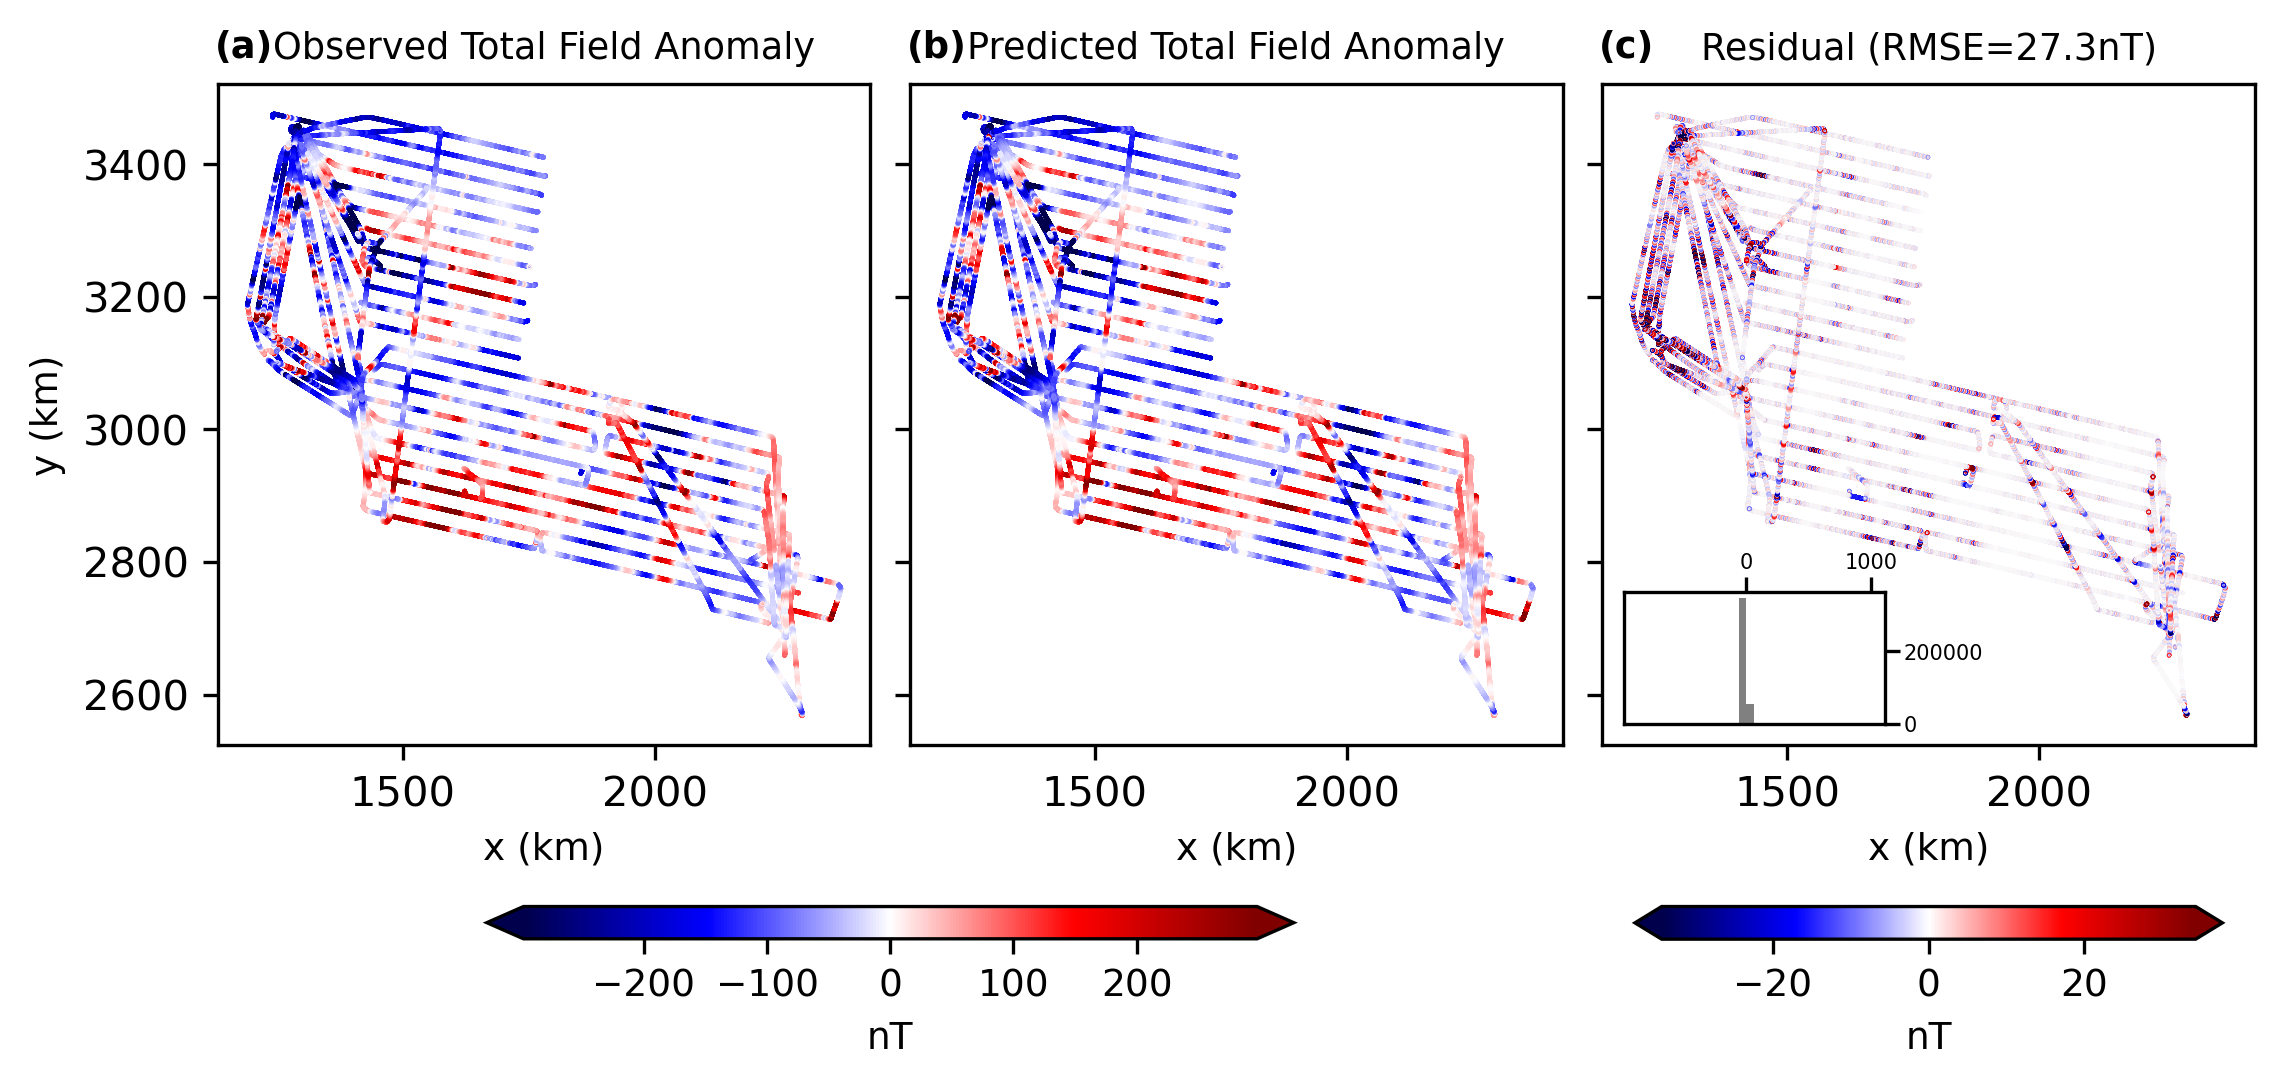

In [30]:
scale_icegrav = np.nanpercentile(icegrav.MagL, 99)
scale_error_tfa = np.nanpercentile(error_tfa, 99)

fig, axes = plt.subplots(1, 3, figsize=(7.5, 3.5), sharey=True, gridspec_kw={'wspace': 0.02}, layout="constrained")
plot1 = axes[0].scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
axes[0].set_title("Observed Total Field Anomaly", fontsize=8.8)
axes[0].set_ylabel("y (km)", fontsize=9)
axes[0].set_xlabel("x (km)", fontsize=9)
axes[0].text(-0.005, 1.04, '(a)', transform=axes[0].transAxes, fontsize=8.8, fontweight='bold')

plot2 = axes[1].scatter(
    *coordinates_km[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
axes[1].set_title("Predicted Total Field Anomaly", fontsize=8.8)
axes[1].set_xlabel("x (km)", fontsize=9)
axes[1].text(-0.005, 1.04, '(b)', transform=axes[1].transAxes, fontsize=8.8, fontweight='bold')

cbar1 = fig.colorbar(plot2, ax=axes[:2], orientation='horizontal', extend='both', pad=0.05, shrink=0.60, aspect=25)
cbar1.set_label("nT", fontsize=9)
cbar1.ax.tick_params(labelsize=9)

plot3 = axes[2].scatter(
    *coordinates_km[:2],
    c=error_tfa,
    cmap="seismic",
    s=0.001,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
axes[2].set_title(f'Residual (RMSE={np.round(rmse_tfa,1)}nT)', fontsize=8.8)
axes[2].set_xlabel("x (km)", fontsize=9)
axes[2].text(-0.005, 1.04, '(c)', transform=axes[2].transAxes, fontsize=8.8, fontweight='bold')

inset_ax = inset_axes( 
    axes[2],
    width="40%",
    height="20%",
    loc="lower left",
    bbox_to_anchor=(0.001, 0.001, 1, 1),
    bbox_transform=axes[2].transAxes,
)
inset_ax.hist(error_tfa[~np.isnan(error_tfa)], bins=30, color="gray")
inset_ax.tick_params(labelsize=5, pad=1)
inset_ax.xaxis.set_ticks_position('top')
inset_ax.xaxis.set_label_position('top')
inset_ax.yaxis.set_ticks_position('right')
inset_ax.yaxis.set_label_position('right')

cbar2 = fig.colorbar(plot3, ax=axes[2], orientation='horizontal', extend='both', pad=0.05, shrink=0.90, aspect=18)
cbar2.set_label("nT", fontsize=9)
cbar2.ax.tick_params(labelsize=9)

# fig.show()
real_line_pred_figure = Path("..") / "paper" / "figures" / "real_line_pred.png"
fig.savefig(real_line_pred_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(real_line_pred_figure)

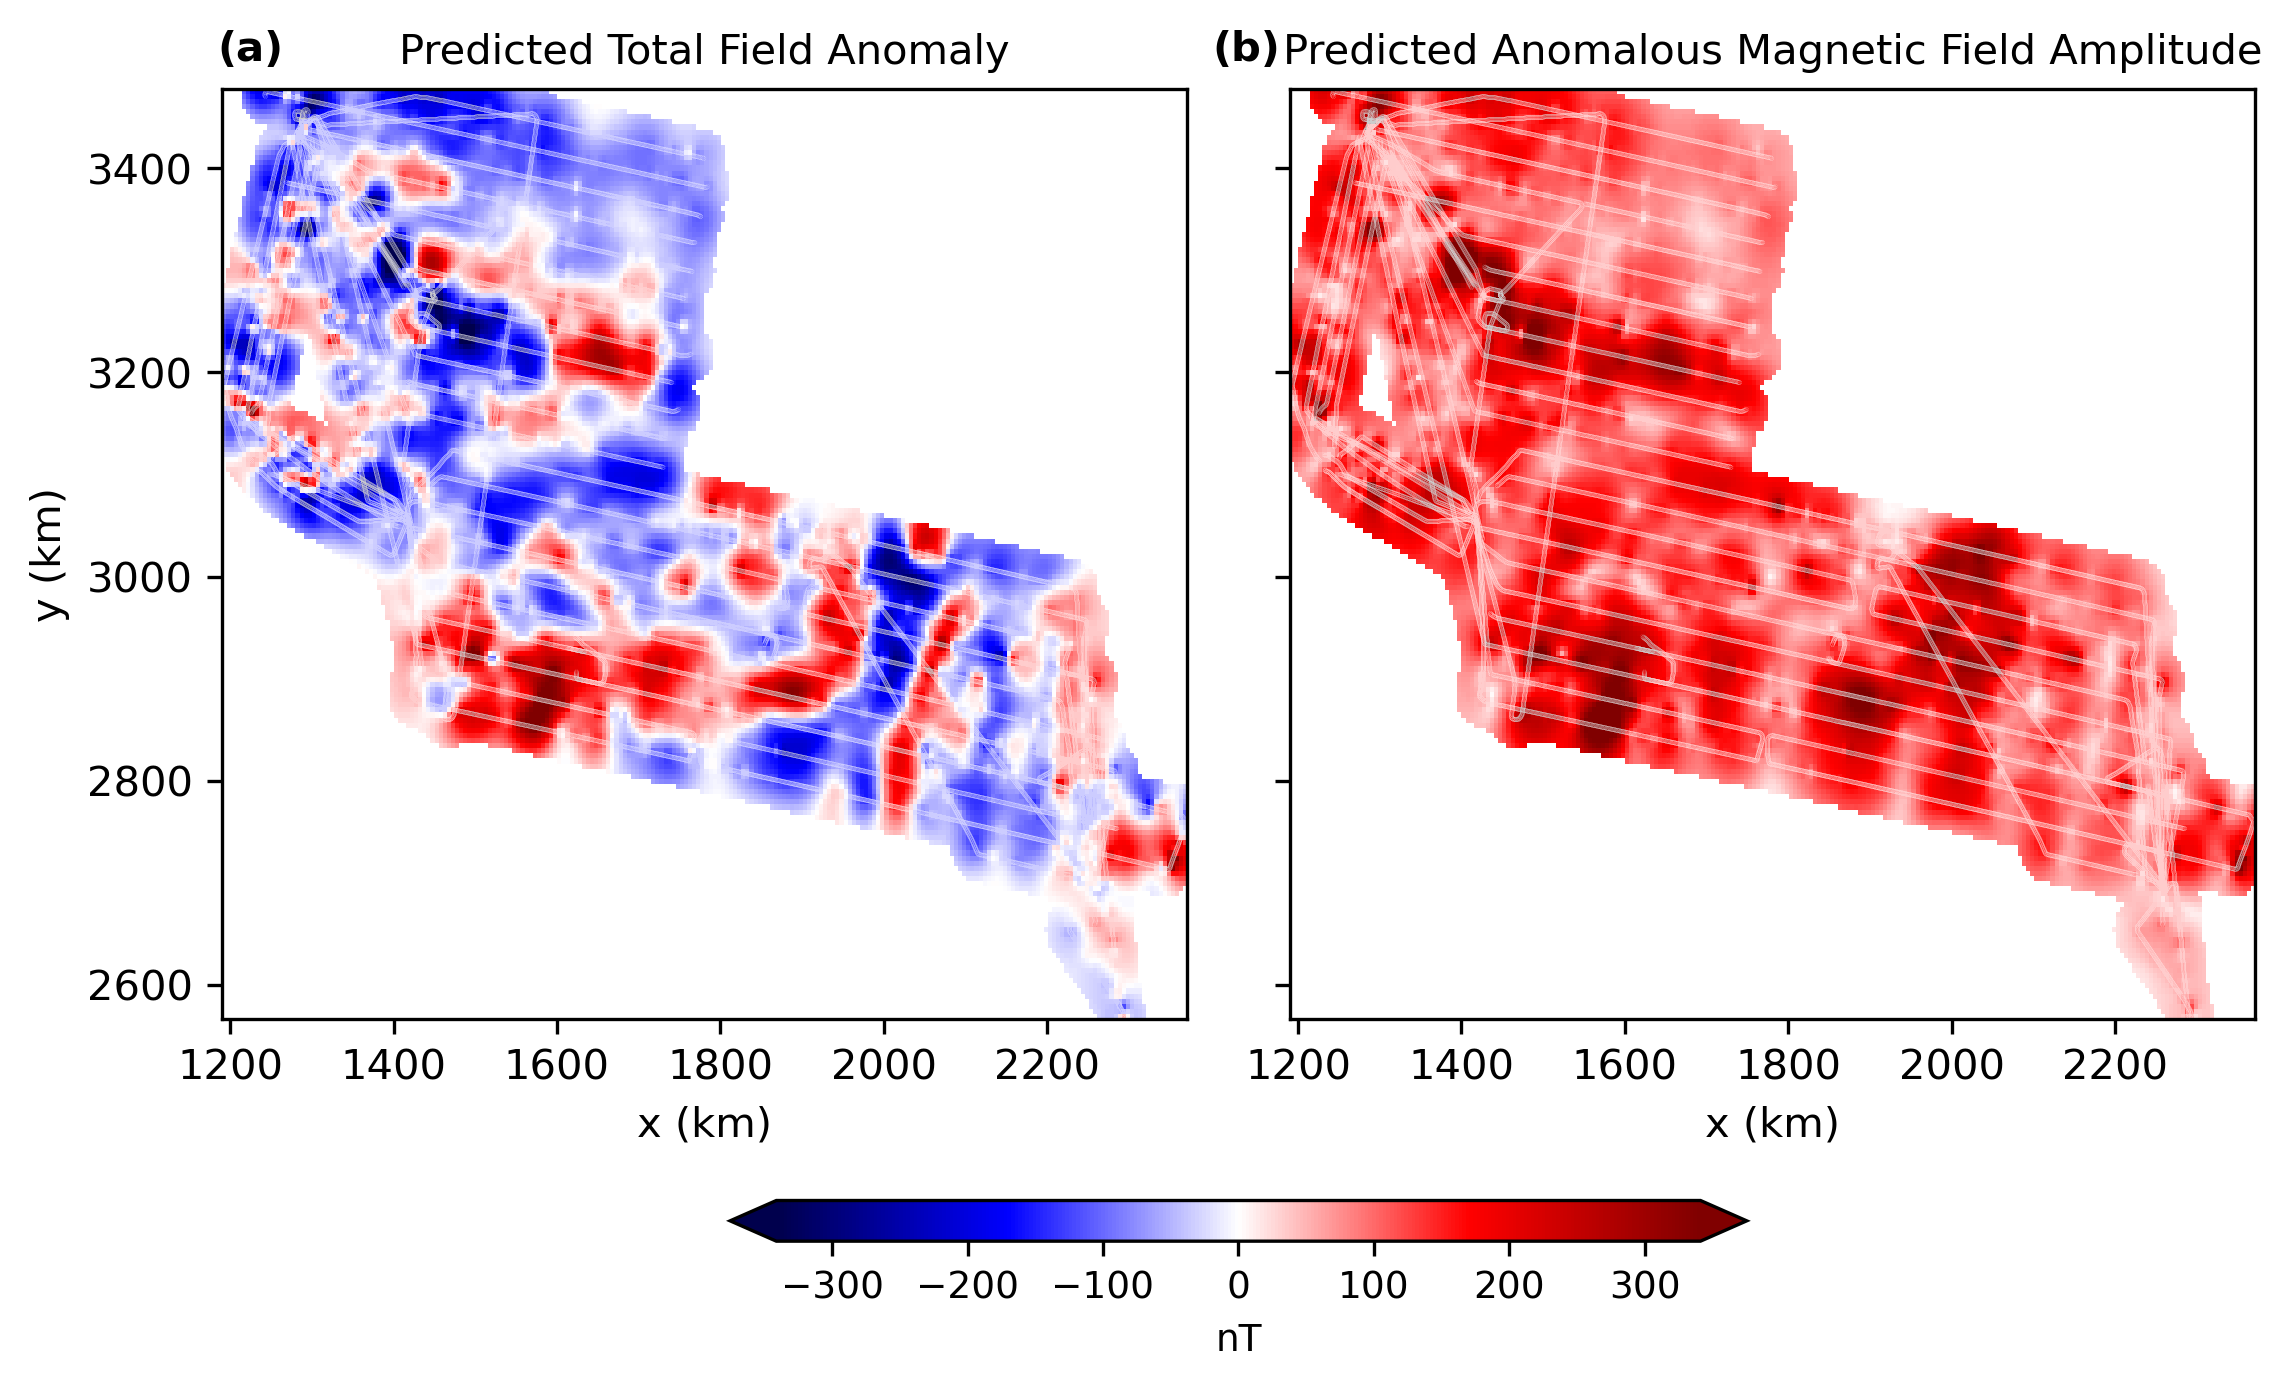

In [31]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7.5,4.5), gridspec_kw={'wspace': 0.02}, layout="constrained")
# scale_predicted_tfa_grid = np.nanpercentile(predicted_tfa_grid, 99)
scale_predicted_bnorm_grid = np.nanpercentile(predicted_bnorm_grid, 99)
plot1 = ax[0].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid,
    cmap="seismic",    
    vmin=-scale_predicted_bnorm_grid,
    vmax=scale_predicted_bnorm_grid,
)
ax[0].set_title("Predicted Total Field Anomaly", fontsize=10)
ax[0].set_xlabel("x (km)", fontsize=10)
ax[0].set_ylabel("y (km)", fontsize=10)
ax[0].plot(*coordinates_km[:2], 'w.', markersize=0.01)
ax[0].text(-0.005, 1.03, '(a)', transform=ax[0].transAxes, fontsize=10, fontweight='bold')

plot2 = ax[1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid,
    cmap="seismic",    
    vmin=-scale_predicted_bnorm_grid,
    vmax=scale_predicted_bnorm_grid,
)
ax[1].set_title("Predicted Anomalous Magnetic Field Amplitude", fontsize=10)
ax[1].set_xlabel("x (km)", fontsize=10)
ax[1].plot(*coordinates_km[:2], 'w.', markersize=0.01)
ax[1].text(-0.08, 1.03, '(b)', transform=ax[1].transAxes, fontsize=10, fontweight='bold')

cbar = fig.colorbar(plot2, ax=ax, orientation='horizontal', extend='both', pad=0.05, shrink=0.5, aspect=25)
cbar.set_label("nT", fontsize=9)
cbar.ax.tick_params(labelsize=9)

# fig.show()
real_grid_pred_figure = Path("..") / "paper" / "figures" / "real_grid_pred.png"
fig.savefig(real_grid_pred_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(real_grid_pred_figure)